# INSTRUCTIONS PROVIDED:

## PRODUCTION:
Dataset containing PLC information on the processing settings at COIL-DATE-MT level.
1. `COIL ID`: of the metal coil processed
1. `MT`:meter observation of the coil (i.e. one observation every 7 meters)
1. `DATE`: day of the year in which the processing of a given COIL-MT started
1. `TIME_START_PROCESS`: time in which the processing started 
1. All the remaining fields are settings refering to the processing of a given COIL-MT.

Hint: check the reliability of the MT variable.

## DEFECTS:
Dataset containing information on the detected defect by coil and type of defect.

This information are gathered during quality control processes after the production.
1. `COIL ID`: of the metal coil processed
1. `MT_FROM`: point of the coil in which a given defect start.
1. `MT_TO`: point in which a given defect end.
1. `DATE`: date in which the coil has been processed.
1. `DIF_TIPO_1`(to6): indicator for the kind of of defect detected.

In [2]:
import sklearn
print(sklearn.__version__)

from sklearn.utils import bootstrap

print("Bootstrap function imported successfully!")


1.4.1.post1


ImportError: cannot import name 'bootstrap' from 'sklearn.utils' (/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/__init__.py)

In [2]:
#imports here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, ParameterGrid, RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, accuracy_score, make_scorer, hamming_loss, precision_score, recall_score, f1_score
from sklearn.inspection import PartialDependenceDisplay
from sklearn.utils import bootstrap
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline
import shap
from joblib import Memory
from sklearn.multioutput import MultiOutputClassifier
import csv
random_state = 42
test_size = 0.2
cachedir = Memory(location='cache_directory', verbose=0)

ImportError: cannot import name 'bootstrap' from 'sklearn.utils' (/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/__init__.py)

In [5]:
#loading data
path_production= '/Users/mattia/Library/CloudStorage/OneDrive-Personal/BBS/05 Machine learnign/00 Fieldwork/4_MANUFACTURING_ROOT CAUSE/RC_PRODUCTION_clean.csv'
path_defects='/Users/mattia/Library/CloudStorage/OneDrive-Personal/BBS/05 Machine learnign/00 Fieldwork/4_MANUFACTURING_ROOT CAUSE/RC_DEFECTS_clean.csv'
production = pd.read_csv(path_production)
defects = pd.read_csv(path_defects, sep=';')

In [6]:
#Data observation
production.head()

,COIL,DATE,MT,TIME_START_PROCESS,SPEED_PROCESS,TEMP_Z1,TEMP_Z2,TEMP_Z3,TEMP_Z4,TEMP_Z5,...,SPZ2_R4,SPZ1_R1_ASS,SPZ1_R2_ASS,TIRO_DECAP,SPEED_FILL,FILL_FORZA,FILL_TIRO,FILL_ALL,FILL_BENDING_POS,FILL_BENDING_NEG
0,240627,2019-03-15,0.0,14:25:23.060,16.934625,671.967562,679.751438,688.119187,716.717250,734.616563,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,240627,2019-03-15,7.0,14:25:53.060,16.773638,668.635875,676.207125,681.034500,710.093250,729.040500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,240627,2019-03-15,14.0,14:26:23.060,11.142165,669.105375,677.042625,678.493125,707.967750,727.783500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,240627,2019-03-15,21.0,14:27:08.060,11.148851,671.631750,681.066000,679.704750,707.241375,727.886250,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,240627,2019-03-15,28.0,14:27:38.060,15.657188,675.052875,686.972813,683.336250,710.432437,730.182375,...,530.110125,14.625,14.625,1956.40875,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
defects.head()


,COIL,MT_FROM,MT_TO,DATE,DIF_TIPO_1,DIF_TIPO_2,DIF_TIPO_3,DIF_TIPO_4,DIF_TIPO_5,DIF_TIPO_6
0,389523,0,599,01/03/19,0,0,1,0,0,0
1,389523,600,1457,01/03/19,0,1,1,0,0,0
2,389528,0,1399,01/03/19,0,0,1,0,0,0
3,389528,1400,1539,01/03/19,0,0,1,0,1,0
4,389712,0,1374,01/03/19,0,0,1,0,0,0


In [8]:
production.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299384 entries, 0 to 299383
Columns: 110 entries, COIL to FILL_BENDING_NEG
dtypes: float64(107), int64(1), object(2)
memory usage: 251.3+ MB


In [9]:
defects.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   COIL        617 non-null    int64 
 1   MT_FROM     617 non-null    int64 
 2   MT_TO       617 non-null    int64 
 3   DATE        617 non-null    object
 4   DIF_TIPO_1  617 non-null    int64 
 5   DIF_TIPO_2  617 non-null    int64 
 6   DIF_TIPO_3  617 non-null    int64 
 7   DIF_TIPO_4  617 non-null    int64 
 8   DIF_TIPO_5  617 non-null    int64 
 9   DIF_TIPO_6  617 non-null    int64 
dtypes: int64(9), object(1)
memory usage: 48.3+ KB


In [10]:
production.sort_values(by=['COIL', 'DATE', 'TIME_START_PROCESS'], inplace=True)
production['MT_REVIEWED'] = production.groupby(['COIL'])['MT'].transform(lambda x: np.arange(start=0, stop=len(x)*7, step=7))
production.drop(columns=['MT'], inplace=True)
column_change=production.pop('MT_REVIEWED')
production.insert(2, 'MT_REVIEWED',column_change)
production.head()

,COIL,DATE,MT_REVIEWED,TIME_START_PROCESS,SPEED_PROCESS,TEMP_Z1,TEMP_Z2,TEMP_Z3,TEMP_Z4,TEMP_Z5,...,SPZ2_R4,SPZ1_R1_ASS,SPZ1_R2_ASS,TIRO_DECAP,SPEED_FILL,FILL_FORZA,FILL_TIRO,FILL_ALL,FILL_BENDING_POS,FILL_BENDING_NEG
0,240627,2019-03-15,0,14:25:23.060,16.934625,671.967562,679.751438,688.119187,716.717250,734.616563,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,240627,2019-03-15,7,14:25:53.060,16.773638,668.635875,676.207125,681.034500,710.093250,729.040500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,240627,2019-03-15,14,14:26:23.060,11.142165,669.105375,677.042625,678.493125,707.967750,727.783500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,240627,2019-03-15,21,14:27:08.060,11.148851,671.631750,681.066000,679.704750,707.241375,727.886250,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,240627,2019-03-15,28,14:27:38.060,15.657188,675.052875,686.972813,683.336250,710.432437,730.182375,...,530.110125,14.625,14.625,1956.40875,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
print(f"Unique COIL values in 'production' dataset: {production['COIL'].nunique()}")
print(f"Unique COIL values in 'defects' dataset: {defects['COIL'].nunique()}")

Unique COIL values in 'production' dataset: 1261
Unique COIL values in 'defects' dataset: 534


Number of missing values in MT: 0


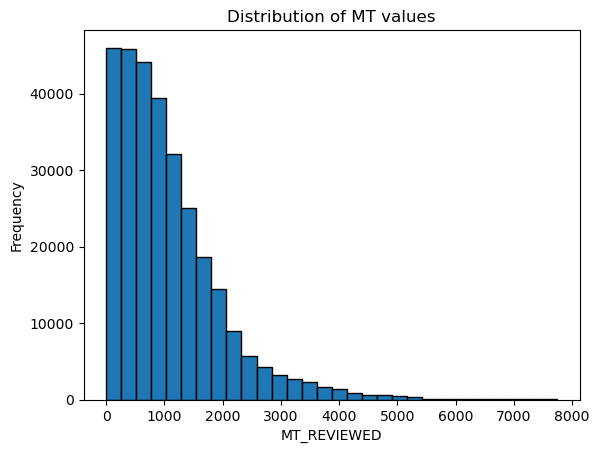

In [12]:
mt_values = production["MT_REVIEWED"]

# Check for missing values
print(f"Number of missing values in MT: {mt_values.isna().sum()}")

# Check the distribution
plt.hist(mt_values.dropna(), bins=30, edgecolor='black')
plt.title("Distribution of MT values")
plt.xlabel("MT_REVIEWED")
plt.ylabel("Frequency")
plt.show()

In [13]:
defects_coils_in_production = defects['COIL'].isin(production['COIL'])
all_coils_present = defects_coils_in_production.all()
print(f"All 'COIL' values in 'defects' are present in 'production': {all_coils_present}")
if not all_coils_present:
    missing_coils = defects.loc[~defects_coils_in_production, 'COIL'].unique()
    print(f"'COIL' values in 'defects' not present in 'production': {missing_coils}")


All 'COIL' values in 'defects' are present in 'production': True


In [14]:
# # Code working for excluding the rows with no defects in the production dataset

# # Create a new column in defects to facilitate the merge
# defects['MT'] = defects.apply(lambda x: list(range(x['MT_FROM'], x['MT_TO']+1)), axis=1)

# # Explode the 'MT' column to create a row for each meter within the defect range
# defects_exploded = defects.explode('MT')

# # Perform the merge on 'COIL' and 'MT'
# merged_df = pd.merge(production, defects_exploded, on=['COIL', 'MT'], how='left', suffixes=('', '_defects'))

# # Now, we need to fill in the defect information for the rows where the defects are present
# # We will create a mask that identifies rows where a defect starts and propagate the defect information forward
# for col in ['DATE', 'DIF_TIPO_1', 'DIF_TIPO_2', 'DIF_TIPO_3', 'DIF_TIPO_4', 'DIF_TIPO_5', 'DIF_TIPO_6']:
#     # Forward-fill the defect information for each COIL group
#     merged_df[col] = merged_df.groupby('COIL')[col].ffill()

# # Filter out the rows where 'MT' is less than 'MT_FROM' and greater than 'MT_TO'
# merged_df = merged_df[(merged_df['MT'] >= merged_df['MT_FROM']) & (merged_df['MT'] <= merged_df['MT_TO'])]

# # Now merged_df should have the defect information and date in the correct rows



In [15]:
# This code creates the new dataframe with the defect information applied to the relevant meter ranges.
merged_df = production.copy()
for i in range(1, 7):
    defect_col = f'DIF_TIPO_{i}'
    merged_df[defect_col] = 0 # or use np.nan, or 0, depending on how you want to represent no defect

def apply_defects(row, production, merged_df):
    coil_id = row['COIL']
    mt_from = row['MT_FROM']
    mt_to = row['MT_TO']
    defect_info = row[['DIF_TIPO_1', 'DIF_TIPO_2', 'DIF_TIPO_3', 'DIF_TIPO_4', 'DIF_TIPO_5', 'DIF_TIPO_6']]
    
    # Filter production for the current coil and meter range
    mask = (production['COIL'] == coil_id) & (production['MT_REVIEWED'] >= mt_from) & (production['MT_REVIEWED'] <= mt_to)
    production_subset = production.loc[mask]
    
    # Update the merged DataFrame with defect information
    for index in production_subset.index:
        merged_df.loc[index, defect_info.index] = defect_info.values

# Apply defects to the production DataFrame
_=defects.apply(lambda row: apply_defects(row, production, merged_df), axis=1)

In [16]:
print(merged_df.shape)
merged_df.head()
#same number of rows as the production dataset

(299384, 116)


,COIL,DATE,MT_REVIEWED,TIME_START_PROCESS,SPEED_PROCESS,TEMP_Z1,TEMP_Z2,TEMP_Z3,TEMP_Z4,TEMP_Z5,...,FILL_TIRO,FILL_ALL,FILL_BENDING_POS,FILL_BENDING_NEG,DIF_TIPO_1,DIF_TIPO_2,DIF_TIPO_3,DIF_TIPO_4,DIF_TIPO_5,DIF_TIPO_6
0,240627,2019-03-15,0,14:25:23.060,16.934625,671.967562,679.751438,688.119187,716.717250,734.616563,...,NaN,NaN,NaN,NaN,0,0,0,0,0,0
1,240627,2019-03-15,7,14:25:53.060,16.773638,668.635875,676.207125,681.034500,710.093250,729.040500,...,NaN,NaN,NaN,NaN,0,0,0,0,0,0
2,240627,2019-03-15,14,14:26:23.060,11.142165,669.105375,677.042625,678.493125,707.967750,727.783500,...,NaN,NaN,NaN,NaN,0,0,0,0,0,0
3,240627,2019-03-15,21,14:27:08.060,11.148851,671.631750,681.066000,679.704750,707.241375,727.886250,...,NaN,NaN,NaN,NaN,0,0,0,0,0,0
4,240627,2019-03-15,28,14:27:38.060,15.657188,675.052875,686.972813,683.336250,710.432437,730.182375,...,NaN,NaN,NaN,NaN,0,0,0,0,0,0


In [17]:
print(f"Number of errors Type_1: {merged_df['DIF_TIPO_1'].value_counts().get(1, 0)}")
print(f"Number of errors Type_2: {merged_df['DIF_TIPO_2'].value_counts().get(1, 0)}")
print(f"Number of errors Type_3: {merged_df['DIF_TIPO_3'].value_counts().get(1, 0)}")
print(f"Number of errors Type_4: {merged_df['DIF_TIPO_4'].value_counts().get(1, 0)}")
print(f"Number of errors Type_5: {merged_df['DIF_TIPO_5'].value_counts().get(1, 0)}")
print(f"Number of errors Type_6: {merged_df['DIF_TIPO_6'].value_counts().get(1, 0)}")

Number of errors Type_1: 6746
Number of errors Type_2: 10044
Number of errors Type_3: 86634
Number of errors Type_4: 51883
Number of errors Type_5: 7589
Number of errors Type_6: 7217


In [18]:
# Code for dropping rows with missing values
nan_counts = merged_df.isnull().sum()
columns_with_nans = nan_counts[nan_counts > 0].index.tolist()
dropped_df = merged_df.dropna(subset=columns_with_nans)
dropped_df

,COIL,DATE,MT_REVIEWED,TIME_START_PROCESS,SPEED_PROCESS,TEMP_Z1,TEMP_Z2,TEMP_Z3,TEMP_Z4,TEMP_Z5,...,FILL_TIRO,FILL_ALL,FILL_BENDING_POS,FILL_BENDING_NEG,DIF_TIPO_1,DIF_TIPO_2,DIF_TIPO_3,DIF_TIPO_4,DIF_TIPO_5,DIF_TIPO_6
170,243941,2019-03-06,28,00:02:59.070,23.610352,1273.28850,1279.944000,1281.003750,1280.850750,1313.777250,...,1224.573750,0.035063,0.258854,0.134993,0,0,0,0,0,0
171,243941,2019-03-06,35,00:03:14.070,23.570531,1272.81000,1280.896875,1282.756875,1280.227500,1310.394375,...,1282.893750,0.026615,0.258924,0.135011,0,0,0,0,0,0
172,243941,2019-03-06,42,00:03:44.070,23.591655,1272.04650,1280.596500,1283.728500,1280.731500,1309.549500,...,1290.660000,0.034612,0.258888,0.135006,0,0,0,0,0,0
173,243941,2019-03-06,49,00:03:59.070,23.583060,1270.78875,1279.190250,1284.021000,1280.661750,1308.818250,...,1289.478750,0.039367,0.258924,0.135024,0,0,0,0,0,0
174,243941,2019-03-06,56,00:04:14.070,23.594212,1269.96750,1277.968125,1284.232500,1281.303750,1308.823125,...,1326.228750,0.038277,0.258899,0.135018,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299365,6838679,2019-04-19,749,10:46:32.860,8.932843,1271.34000,1277.043750,1259.679375,1262.975625,1276.233750,...,1646.521875,0.034937,0.258947,0.135017,0,0,0,0,0,0
299366,6838679,2019-04-19,756,10:47:32.860,8.948430,1267.99875,1278.011250,1261.586250,1267.042500,1278.022500,...,1674.438750,0.038531,0.258911,0.134953,0,0,0,0,0,0
299367,6838679,2019-04-19,763,10:48:17.860,8.951884,1269.88875,1279.816875,1264.786875,1270.957500,1283.366250,...,1666.507500,0.038778,0.258913,0.135053,0,0,0,0,0,0
299368,6838679,2019-04-19,770,10:49:17.860,8.977444,1266.59250,1280.936250,1265.782500,1271.475000,1285.683750,...,1671.665625,0.035091,0.258892,0.135005,0,0,0,0,0,0


In [19]:
print(f"Number of errors Type_1: {dropped_df['DIF_TIPO_1'].value_counts().get(1, 0)}")
print(f"Number of errors Type_2: {dropped_df['DIF_TIPO_2'].value_counts().get(1, 0)}")
print(f"Number of errors Type_3: {dropped_df['DIF_TIPO_3'].value_counts().get(1, 0)}")
print(f"Number of errors Type_4: {dropped_df['DIF_TIPO_4'].value_counts().get(1, 0)}")
print(f"Number of errors Type_5: {dropped_df['DIF_TIPO_5'].value_counts().get(1, 0)}")
print(f"Number of errors Type_6: {dropped_df['DIF_TIPO_6'].value_counts().get(1, 0)}")

Number of errors Type_1: 6174
Number of errors Type_2: 8678
Number of errors Type_3: 77925
Number of errors Type_4: 47572
Number of errors Type_5: 6680
Number of errors Type_6: 6583


In [20]:
X=dropped_df.loc[:, 'SPEED_PROCESS':'FILL_BENDING_NEG']
X.head()

,SPEED_PROCESS,TEMP_Z1,TEMP_Z2,TEMP_Z3,TEMP_Z4,TEMP_Z5,TEMP_Z6,PYRO_1_PRECHMBR,PYRO_2_FRST_3_ZONE,PYRO_3_LST_3_ZONE,...,SPZ2_R4,SPZ1_R1_ASS,SPZ1_R2_ASS,TIRO_DECAP,SPEED_FILL,FILL_FORZA,FILL_TIRO,FILL_ALL,FILL_BENDING_POS,FILL_BENDING_NEG
170,23.610352,1273.28850,1279.944000,1281.003750,1280.85075,1313.777250,1287.848250,867.159450,1100.796300,1143.731250,...,0.000000,0.000000,0.000,4244.88375,7.752319,198.895500,1224.57375,0.035063,0.258854,0.134993
171,23.570531,1272.81000,1280.896875,1282.756875,1280.22750,1310.394375,1286.454375,866.311688,1100.555063,1142.737500,...,0.000000,19.993500,21.375,4242.94875,12.563663,231.608250,1282.89375,0.026615,0.258924,0.135011
172,23.591655,1272.04650,1280.596500,1283.728500,1280.73150,1309.549500,1284.502500,860.741550,1100.221200,1137.415500,...,530.302500,21.352500,21.375,4243.57875,12.157837,221.544375,1290.66000,0.034612,0.258888,0.135006
173,23.583060,1270.78875,1279.190250,1284.021000,1280.66175,1308.818250,1283.818500,855.048825,1107.692775,1140.646500,...,531.106875,21.231000,21.375,4244.62500,11.856412,224.306625,1289.47875,0.039367,0.258924,0.135024
174,23.594212,1269.96750,1277.968125,1284.232500,1281.30375,1308.823125,1284.369375,855.170625,1099.023750,1143.309375,...,530.163000,20.293537,21.375,4243.79250,11.638350,212.985000,1326.22875,0.038277,0.258899,0.135018


In [21]:
y=dropped_df.loc[:, 'DIF_TIPO_1':'DIF_TIPO_6']
y.head()

,DIF_TIPO_1,DIF_TIPO_2,DIF_TIPO_3,DIF_TIPO_4,DIF_TIPO_5,DIF_TIPO_6
170,0,0,0,0,0,0
171,0,0,0,0,0,0
172,0,0,0,0,0,0
173,0,0,0,0,0,0
174,0,0,0,0,0,0


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
print('There are {} samples in the training dataset'.format(X_train.shape[0]))
print("There are {} samples in the testing dataset".format(X_test.shape[0]))
print("Each sample has {} features".format(X_train.shape[1]))

There are 208510 samples in the training dataset
There are 52128 samples in the testing dataset
Each sample has 106 features


In [61]:
# Sum up the occurrences of each error type in the training set
train_error_counts = y_train.sum(axis=0)

# Sum up the occurrences of each error type in the testing set
test_error_counts = y_test.sum(axis=0)

# Create a DataFrame to hold the counts
error_counts_df = pd.DataFrame({
    'Error Type': ['DIF_TIPO_1', 'DIF_TIPO_2', 'DIF_TIPO_3', 'DIF_TIPO_4', 'DIF_TIPO_5', 'DIF_TIPO_6'],
    'Training Set': train_error_counts.values,
    'Testing Set': test_error_counts.values
})

# Print the DataFrame
print(error_counts_df)


   Error Type  Training Set  Testing Set
0  DIF_TIPO_1          4958         1216
1  DIF_TIPO_2          6950         1728
2  DIF_TIPO_3         62339        15586
3  DIF_TIPO_4         38084         9488
4  DIF_TIPO_5          5337         1343
5  DIF_TIPO_6          5310         1273


In [40]:
# Decision Tree CLF
clf = DecisionTreeClassifier(random_state=random_state)
multioutput_clf = MultiOutputClassifier(clf, n_jobs=-1)
param_grid = {
    'estimator__max_depth': [5, 10, None],  # Example depths
    'estimator__min_samples_split': [2, 5],
    'estimator__min_samples_leaf': [1, 2],
    'estimator__max_features': ['sqrt', 'log2', None]  # Include None for considering all features
}

hamming_scorer = make_scorer(hamming_loss, greater_is_better=False)
grid_search = GridSearchCV(
    estimator=multioutput_clf,
    param_grid=param_grid,
    cv=2,  # Reduced from 3 to 2
    n_jobs=-1,
    verbose=2,
    scoring=hamming_scorer
)
grid_search.fit(X_train, y_train)


# # Random Forest CLF
# clf = RandomForestClassifier(random_state=random_state)
# multioutput_clf = MultiOutputClassifier(clf, n_jobs=-1)
# param_grid = {
#     'estimator__n_estimators': [50, 100],          # Reduced number of trees [100, 150, 200]
#     'estimator__max_depth': [5, 10],               # Reduced depth of trees [10, 20, 30, None]
#     'estimator__min_samples_split': [2, 5],
#     'estimator__min_samples_leaf': [1, 2],
#     'estimator__max_features': ['sqrt', 'log2'],
#     'estimator__bootstrap': [True]
# }
# hamming_scorer = make_scorer(hamming_loss, greater_is_better=False)

# grid_search = GridSearchCV(
#     estimator=multioutput_clf, 
#     param_grid=param_grid, 
#     cv=2,                               # Reduced from 3 to 2
#     n_jobs=-1, 
#     verbose=2)
# grid_search.fit(X_train, y_train)
# best_clf = grid_search.best_estimator_



# # Random Search CV 
# random_search = RandomizedSearchCV(        
#     multioutput_clf,
#     param_distributions=param_grid,
#     n_iter=5,                           # Reduced from 10 to 5
#     cv=2,                               # Reduced from 3 to 2
#     n_jobs=-1,
#     verbose=2,
#     scoring=hamming_scorer,
#     random_state=random_state
# )
# random_search.fit(X_train, y_train)
# best_pipeline = random_search.best_estimator_



Fitting 2 folds for each of 36 candidates, totalling 72 fits
[CV] END estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=5; total time=   2.8s
[CV] END estimator__max_depth=5, estimator__max_features=log2, estimator__min_samples_leaf=1, estimator__min_samples_split=2; total time=   3.6s
[CV] END estimator__max_depth=5, estimator__max_features=log2, estimator__min_samples_leaf=1, estimator__min_samples_split=2; total time=   3.7s
[CV] END estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2; total time=   4.9s
[CV] END estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5; total time=   5.0s
[CV] END estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2; total time=   5.0s
[CV] END estimator__max_depth=5, estimator__max_features=sqrt, estima

GridSearchCV(cv=2,
             estimator=MultiOutputClassifier(estimator=DecisionTreeClassifier(random_state=42),
                                             n_jobs=-1),
             n_jobs=-1,
             param_grid={'estimator__max_depth': [5, 10, None],
                         'estimator__max_features': ['sqrt', 'log2', None],
                         'estimator__min_samples_leaf': [1, 2],
                         'estimator__min_samples_split': [2, 5]},
             scoring=make_scorer(hamming_loss, greater_is_better=False),
             verbose=2)

In [50]:
best_clf = grid_search.best_estimator_
best_params = grid_search.best_params_
# Assuming you have already made predictions on the test set with your best model
y_pred = best_clf.predict(X_test)

# Calculate the accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Calculate the Hamming loss (the lower, the better)
hammingloss = hamming_loss(y_test, y_pred)
print(f"Hamming Loss: {hammingloss:.4f}")

# Generate a classification report
report = classification_report(y_test, y_pred, target_names=['DIF_TIPO_1', 'DIF_TIPO_2', 'DIF_TIPO_3', 'DIF_TIPO_4', 'DIF_TIPO_5', 'DIF_TIPO_6'])
print(report)

# If you want to calculate other metrics, such as precision, recall, and F1-score for each label, you can do so as follows:
precision = precision_score(y_test, y_pred, average=None, zero_division=0)  # Returns precision for each label
recall = recall_score(y_test, y_pred, average=None)        # Returns recall for each label
f1 = f1_score(y_test, y_pred, average=None)                # Returns F1 score for each label

print(f"Precision per label: {precision}")
print(f"Recall per label: {recall}")
print(f"F1 Score per label: {f1}")

# To get a single summary metric for precision, recall, and F1-score, you can use average='micro', 'macro', or 'weighted':
precision_macro = precision_score(y_test, y_pred, average='macro', zero_division=0)
recall_macro = recall_score(y_test, y_pred, average='macro', zero_division=0)
f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)

print(f"Macro Precision: {precision_macro:.4f}")
print(f"Macro Recall: {recall_macro:.4f}")
print(f"Macro F1 Score: {f1_macro:.4f}")

# Micro-average will aggregate the contributions of all classes to compute the average metric
precision_micro = precision_score(y_test, y_pred, average='micro', zero_division=0)
recall_micro = recall_score(y_test, y_pred, average='micro', zero_division=0)
f1_micro = f1_score(y_test, y_pred, average='micro', zero_division=0)

print(f"Micro Precision: {precision_micro:.4f}")
print(f"Micro Recall: {recall_micro:.4f}")
print(f"Micro F1 Score: {f1_micro:.4f}")

# Weighted-average will account for class imbalance by computing the average of precision, recall, and F1-score, weighted by the number of true instances for each label
precision_weighted = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall_weighted = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1_weighted = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print(f"Weighted Precision: {precision_weighted:.4f}")
print(f"Weighted Recall: {recall_weighted:.4f}")
print(f"Weighted F1 Score: {f1_weighted:.4f}")


Accuracy: 0.9842
Hamming Loss: 0.0028
              precision    recall  f1-score   support

  DIF_TIPO_1       0.96      0.96      0.96      1216
  DIF_TIPO_2       0.96      0.97      0.96      1728
  DIF_TIPO_3       0.99      0.99      0.99     15586
  DIF_TIPO_4       0.99      0.99      0.99      9488
  DIF_TIPO_5       0.98      0.97      0.97      1343
  DIF_TIPO_6       0.98      0.99      0.99      1273

   micro avg       0.99      0.99      0.99     30634
   macro avg       0.98      0.98      0.98     30634
weighted avg       0.99      0.99      0.99     30634
 samples avg       0.37      0.36      0.36     30634

Precision per label: [0.95723684 0.96360485 0.99031741 0.98817568 0.97590361 0.98208723]
Recall per label: [0.95723684 0.96527778 0.99088926 0.98650927 0.96500372 0.99057345]
F1 Score per label: [0.95723684 0.96444059 0.99060325 0.98734177 0.97042306 0.98631208]
Macro Precision: 0.9762
Macro Recall: 0.9759
Macro F1 Score: 0.9761


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Micro Precision: 0.9859
Micro Recall: 0.9856
Micro F1 Score: 0.9857
Weighted Precision: 0.9859
Weighted Recall: 0.9856
Weighted F1 Score: 0.9857


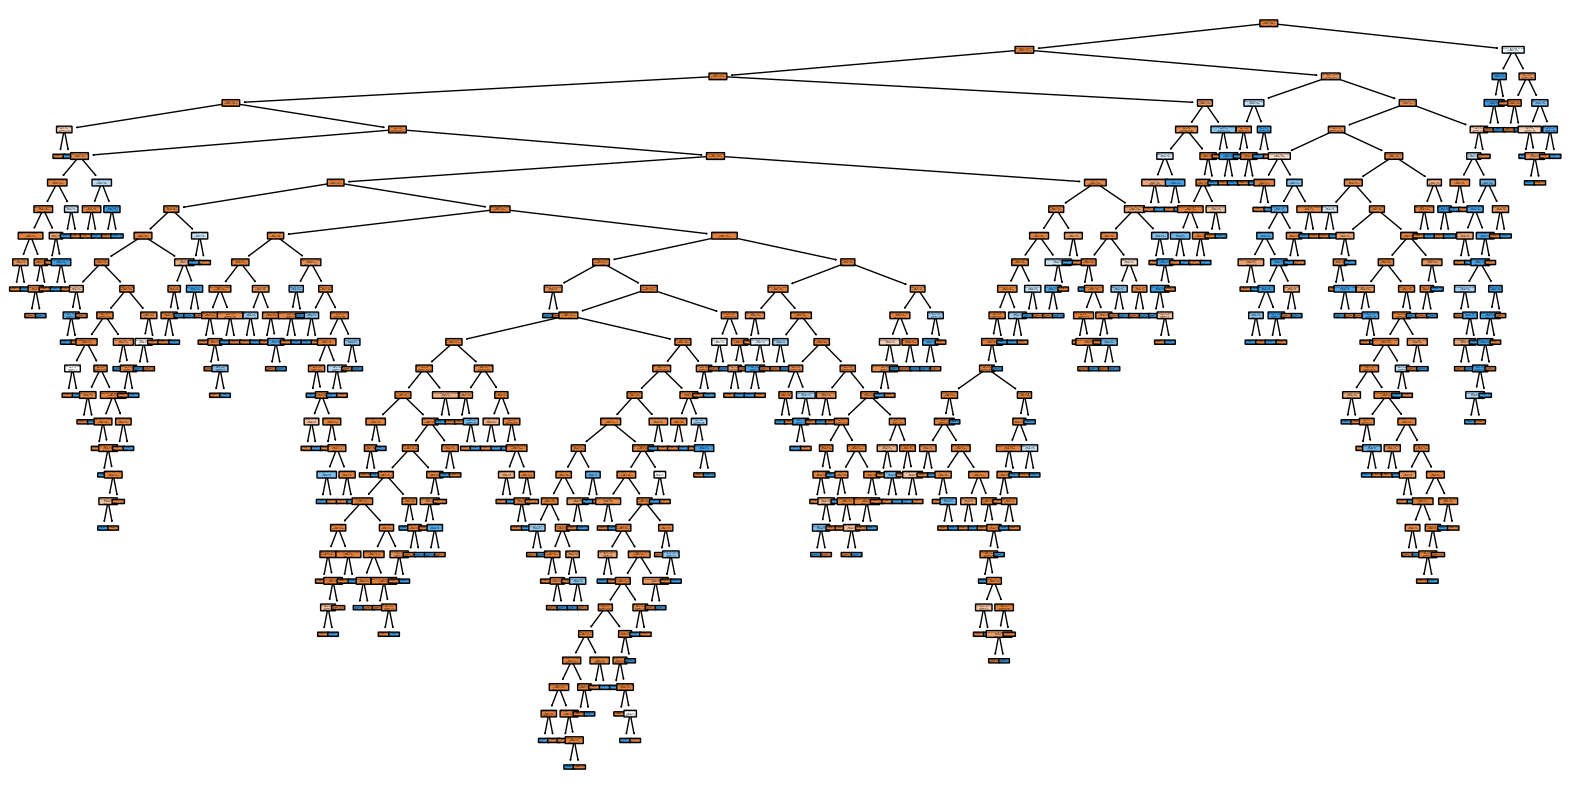

In [67]:
single_tree = best_clf.estimators_[0]  # Index 0 for the first label, for example
feature_names_list = X_train.columns.tolist()

# Plot the decision tree
plt.figure(figsize=(20, 10))  # Set the figure size (width, height) in inches
plot_tree(single_tree, 
          filled=True, 
          feature_names=feature_names_list, 
          rounded=True, 
          proportion=False, 
          precision=2)
plt.show()


## Built-in Feature Importance
Most tree-based models in libraries like scikit-learn have a built-in feature_importances_ attribute after the model has been fitted. This provides a simple way to see the relative importance of each feature

In [69]:
# Assuming clf is your trained Decision Tree or ensemble model
importances = best_clf.estimators_[0].feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(X_train.shape[1]):
    print("%d. Feature %s (%f)" % (f + 1, X_train.columns[indices[f]], importances[indices[f]]))

Feature ranking:
1. Feature SPZ1_R2_ASS (0.093227)
2. Feature TIRO_DECAP (0.088273)
3. Feature FRN_PHF_PRESSURE (0.082390)
4. Feature ELET_H2SO4 (0.071826)
5. Feature VENT_5 (0.064574)
6. Feature SPEED_PROCESS (0.057340)
7. Feature TOUT_RAFF_H2O (0.040781)
8. Feature DEC_H2SO4 (0.039393)
9. Feature VENT_2 (0.032966)
10. Feature SPZ1_R1_ASS (0.031836)
11. Feature PYRO_3_LST_3_ZONE (0.028152)
12. Feature EXT_1 (0.025559)
13. Feature ELET_FE2 (0.023553)
14. Feature LASER_FRN_2 (0.021092)
15. Feature FILL_FORZA (0.019360)
16. Feature DEC_TEMP (0.018354)
17. Feature VENT_3 (0.016046)
18. Feature TEMP_Z3 (0.014826)
19. Feature AIR_Z3_1 (0.013799)
20. Feature LASER_FRN_3 (0.013639)
21. Feature DEC_FE2 (0.013636)
22. Feature DEC_FETOT (0.012080)
23. Feature GAS_Z2_1 (0.010687)
24. Feature PYRO_2_FRST_3_ZONE (0.010510)
25. Feature FILL_TIRO (0.009855)
26. Feature LS_OVEN (0.009528)
27. Feature ELET_CORRENTE (0.008570)
28. Feature DEC_HF (0.007933)
29. Feature FILL_ALL (0.007924)
30. Feature SPZ

In [72]:
# # For export to a csv file
# feature_ranking = []
# # Append the feature ranking information to the list
# for f in range(X_train.shape[1]):
#     feature_ranking.append([f + 1, X_train.columns[indices[f]], importances[indices[f]]])

# # Write the feature ranking information to a CSV file
# with open('feature_ranking.csv', 'w', newline='') as csvfile:
#     writer = csv.writer(csvfile)
#     writer.writerow(['Rank', 'Feature', 'Importance'])
#     writer.writerows(feature_ranking)

## Permutation Importance
Permutation importance is a model inspection technique that can be used for any fitted estimator when the data is tabular. This technique is calculated after a model has been fitted and involves randomly shuffling individual features in the validation set and measuring how the score (like accuracy) decreases. A large decrease in model score signifies the importance of the feature.

In [74]:
from sklearn.inspection import permutation_importance

result = permutation_importance(best_clf.estimators_[0], X_test, y_test.iloc[:, 0], n_repeats=10, random_state=42, n_jobs=-1)

sorted_idx = result.importances_mean.argsort()

for i in sorted_idx[::-1]:
    print(f"{X_test.columns[i]}: {result.importances_mean[i]:.4f}")


TIRO_DECAP: 0.0524
TIRO_FORNO: 0.0320
ELET_H2SO4: 0.0105
SPEED_PROCESS: 0.0095
SPEED_FILL: 0.0071
SPZ1_R2_ASS: 0.0065
TEMP_Z4: 0.0056
FILL_ALL: 0.0055
AIR_Z1_1: 0.0052
DEC_H2SO4: 0.0050
FILL_FORZA: 0.0044
FILL_TIRO: 0.0044
FRN_PHF_PRESSURE: 0.0043
VENT_5: 0.0038
SPZ1_R1_ASS: 0.0037
LASER_FRN_4: 0.0036
TOUT_RAFF_H2O: 0.0032
TEMP_Z5: 0.0031
ELET_FE2: 0.0029
DEC_FE2: 0.0027
AIR_CH4_2: 0.0025
VENT_2: 0.0025
LASER_FRN_1: 0.0024
GAS_Z6_2: 0.0023
AIR_Z3_1: 0.0022
PYRO_3_LST_3_ZONE: 0.0022
ELET_CORRENTE: 0.0022
DEC_HF: 0.0020
DEC_TEMP: 0.0019
VENT_3: 0.0019
EXT_1: 0.0018
AIR_CH4_3: 0.0018
LASER_FRN_2: 0.0016
ELET_TEMP: 0.0014
LASER_FRN_9: 0.0014
TEMP_Z3: 0.0013
COOL_3: 0.0013
AIR_CH4_4: 0.0013
PRES_ZONA1_MEASURED: 0.0012
VENT_1: 0.0011
GAS_Z6_1: 0.0009
DEC_FETOT: 0.0008
AIR_Z1_2: 0.0008
SPZ2_R4: 0.0006
PYRO_2_FRST_3_ZONE: 0.0006
AIR_CH4_1: 0.0006
GAS_Z3_2: 0.0006
LASER_FRN_8: 0.0006
LASER_RAFF_3: 0.0006
FILL_BENDING_POS: 0.0005
LASER_FRN_3: 0.0005
SPZ2_R3: 0.0005
GAS_Z4_2: 0.0005
PRES_ZONA3_ME

In [75]:
# # Export to excel
# importances_df = pd.DataFrame({
#     'Feature': X_test.columns,
#     'Importance_mean': result.importances_mean,
#     'Importance_std': result.importances_std
# })
# importances_df = importances_df.sort_values(by='Importance_mean', ascending=False).reset_index(drop=True)
# importances_df.to_excel('feature_importances.xlsx', index=False)

## Partial Dependence Plots
Partial dependence plots (PDPs) show the dependence between the target response and a set of 'target' features, marginalizing over the values of all other features. PDPs can show whether the relationship between the target and a feature is linear, monotonic, or more complex.

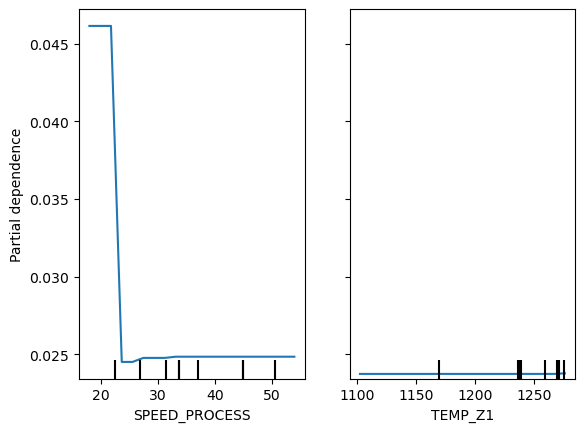

In [79]:
from sklearn.inspection import PartialDependenceDisplay

# Assuming you have a fitted model called 'best_estimator_for_target'
# and you want to plot partial dependence for a specific target (e.g., the first one)
best_estimator_for_target = best_clf.estimators_[0]

# Specify the features for which you want to plot the PDPs
features = [0, 1]  # Replace with the indices or names of the features you are interested in

# Create the partial dependence plot
PartialDependenceDisplay.from_estimator(
    best_estimator_for_target,
    X_train,
    features,
    kind="average",  # or 'individual' or 'both'
    grid_resolution=20  # Number of grid points to use for numeric features
)

# If you want to save the figure, you can do so by accessing the matplotlib axes
import matplotlib.pyplot as plt
plt.savefig('partial_dependence_plot.png')  # Save the plot as a PNG file


## SHAP Values
SHAP (SHapley Additive exPlanations) values break down a prediction to show the impact of each feature. Unlike simple feature importance, SHAP values can show how a feature contributed to each individual prediction, as well as on average. SHAP values can be complex to calculate but provide a very detailed understanding of model behavior.

In [82]:
# Loop over each fitted classifier for each target and create SHAP values
for i, estimator in enumerate(best_clf.estimators_):
    # Create a SHAP explainer for the i-th estimator
    explainer = shap.TreeExplainer(estimator)

    # Calculate SHAP values for the i-th target
    shap_values = explainer.shap_values(X_test)

    # Plot summary plot using SHAP values for the i-th target
    shap.summary_plot(shap_values, X_test, feature_names=X_test.columns, show=False)

    # Save the plot for each target
    plt.savefig(f'shap_summary_plot_target_{i}.png')
    plt.clf()  # Clear the current figure for the next plot


<Figure size 1150x660 with 0 Axes>

<Figure size 1150x660 with 0 Axes>

<Figure size 1150x660 with 0 Axes>

<Figure size 1150x660 with 0 Axes>

<Figure size 1150x660 with 0 Axes>

<Figure size 1150x660 with 0 Axes>

1.4.1.post1
